In [35]:
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from pprint import pprint
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import ExtraTreesClassifier
import numpy as np
from imblearn.over_sampling import SMOTE

from sklearn.dummy import DummyClassifier
import itertools
import warnings
warnings.simplefilter('ignore')
%run -i 'functions.py'

Using TensorFlow backend.
ERROR:root:File `'functions.py'` not found.


In [7]:
pd.set_option('display.max_columns', None)
train= pd.read_csv('clean_train.csv')
test= pd.read_csv('clean_test.csv')

In [11]:
train.shape

(59400, 237)

In [12]:
test.shape

(14850, 235)

In [48]:
train.dtypes

id                                               int64
status_group                                     int64
amount_tsh                                     float64
date_recorded                                   object
funder                                          object
                                                ...   
waterpoint_type_communal standpipe multiple      int64
waterpoint_type_dam                              int64
waterpoint_type_hand pump                        int64
waterpoint_type_improved spring                  int64
waterpoint_type_other                            int64
Length: 236, dtype: object

In [13]:
train.columns.difference(test.columns)

Index(['scheme_management_None', 'status_group'], dtype='object')

In [14]:
train.drop(columns = ['scheme_management_None',], inplace=True)

In [15]:
train.shape,test.shape

((59400, 236), (14850, 235))

## Feature Set

In [72]:
X = train.drop(columns = ['id', 'status_group','date_recorded','funder','installer']).values
y = train['status_group'].values
X_r, y_r = SMOTE().fit_sample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_r, y_r, test_size=0.2, random_state=42)

In [73]:
print('Training set: ', X_train.shape, y_train.shape)
print('Testing set: ', X_test.shape, y_test.shape)

Training set:  (77421, 231) (77421,)
Testing set:  (19356, 231) (19356,)


## Dummy Classifier 

In [74]:
dummy_clf = DummyClassifier(strategy= 'most_frequent').fit(X_train,y_train)
dummy_pred = dummy_clf.predict(X_test)
dummy_clf.score(X_train, y_train)

0.3342245643946733

In [75]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=2)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

In [76]:
cm = confusion_matrix(y_test,dummy_pred)
classes = ['Functional', 'Functional needs repair','NonFunctional']

Confusion Matrix, without normalization
[[   0    0 6540]
 [   0    0 6433]
 [   0    0 6383]]


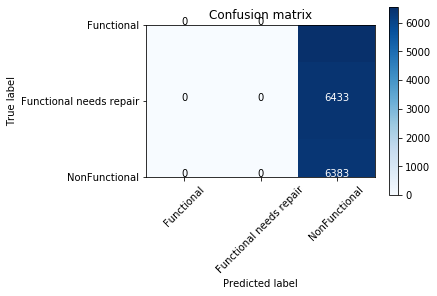

In [77]:
plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

## Random Classifier 

In [71]:
rfc = RandomForestClassifier(criterion='entropy', max_depth=None).fit(X_train, y_train)

In [79]:
yhat = rfc.predict(X_test)

In [81]:
print('Train set Accuracy: ', metrics.accuracy_score(y_train, rfc.predict(X_train)))
print('Test set Accuracy: ', metrics.accuracy_score(y_test, yhat))

Train set Accuracy:  0.8361038994588031
Test set Accuracy:  0.8221740028931598


## Hyper Tuning 

In [88]:
param_grid = {
    'n_estimators': [50, 100],
    'criterion':['gini', 'entropy'],
    'min_samples_leaf':[2,4],
    'min_samples_split':[3,5],
    'bootstrap': [True, False]
}


grid_rfc = GridSearchCV(RandomForestClassifier(), 
                        rfc_params, 
                        cv=3, 
                        scoring='accuracy').fit(X_train, y_train)

In [89]:
gridsearch_ = grid_rfc.predict(X_test)


In [91]:
print('Train set Accuracy: ', metrics.accuracy_score(y_train, grid_rfc.predict(X_train)))
print('Test set Accuracy: ', metrics.accuracy_score(y_test, gridsearch_))

Train set Accuracy:  0.9679544309683419
Test set Accuracy:  0.8627299028724943


In [92]:
cm = confusion_matrix(yhat,gridsearch_)
classes = ['Functional', 'Functional needs repair','NonFunctional']

Confusion Matrix, without normalization
[[5925 2287  632]
 [ 192 3597   87]
 [ 670  708 5258]]


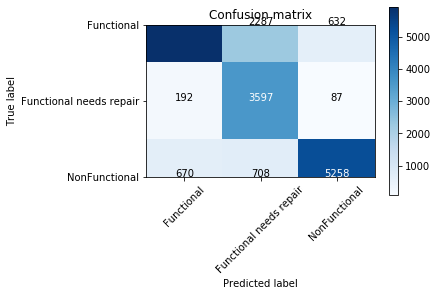

In [93]:
plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

## Predicitons

In [96]:
testdf = test.drop(columns = ['id','date_recorded','funder','installer']).values

In [97]:
yhat2 = grid_rfc.predict(testdf)

In [98]:
prediction = pd.DataFrame(yhat2)

In [104]:
prediction.head()

,0
0,2
1,0
2,0
3,2
4,0


In [106]:
prediction = pd.concat((test['id'], prediction), axis=1)

In [107]:
prediction.columns=['id', 'status_group']

In [115]:
prediction.head()

,id,status_group
0,50785,2
1,51630,0
2,17168,0
3,45559,2
4,49871,0


These are value counts the status group that I predicted from the test set. There are 8165 Functional pumps, 5506 Non Functional pumps, and 1179 Functional needs repair. 

In [113]:
prediction['status_group'].value_counts()

0    8165
2    5506
1    1179
Name: status_group, dtype: int64

In comparisson to train dataset. These are value counts the status group from the train dataset. 

In [114]:
train['status_group'].value_counts()

0    32259
2    22824
1     4317
Name: status_group, dtype: int64

## KNN

In [116]:
model = KNeighborsClassifier(n_neighbors=6)
model.fit(X_train, y_train)

y_predknn = model.predict(X_test)

In [118]:
cm = confusion_matrix(y_test, y_predknn)
classes = ['Functional', 'Functional needs repair','NonFunctional']

Confusion Matrix, without normalization
[[4502 1009 1029]
 [ 579 5618  236]
 [1396  743 4244]]


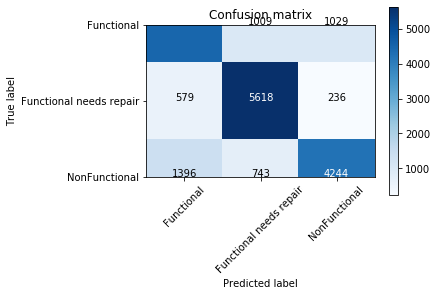

In [119]:
plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

In [142]:
from sklearn.model_selection import cross_val_score

In [146]:
k_range = list(range(1, 12))
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_predict = knn.predict(X_test)
    scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
    k_scores.append(scores.mean())
print(k_scores)   

[0.6781481481481482, 0.6877777777777777, 0.6996127946127947, 0.7003030303030303, 0.7021548821548821, 0.7036868686868687, 0.7034175084175084, 0.7043097643097643, 0.7048484848484848, 0.7052525252525252, 0.7038720538720539]


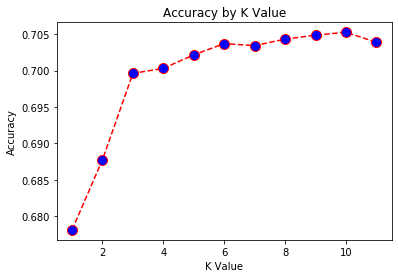

In [153]:
plt.plot(range(1, 12), k_scores, color='red', linestyle='dashed', marker='o',  
             markerfacecolor='blue', markersize=10)
plt.title('Accuracy by K Value')  
plt.xlabel('K Value')  
plt.ylabel('Accuracy') 
plt.show()

In [163]:
print ( "The best value of K is 10, with an accuracy of", max(k_scores))

The best value of K is 10, with an accuracy of 0.7052525252525252


In [150]:
model2 = KNeighborsClassifier(n_neighbors=1)
model2.fit(X_train, y_train)

y_predknnbest = model2.predict(X_test)

In [151]:
cm1 = confusion_matrix(y_test,y_predknnbest)
classes = ['Functional', 'Functional needs repair','NonFunctional']

Confusion Matrix, without normalization
[[4450  739 1351]
 [ 472 5711  250]
 [1027  409 4947]]


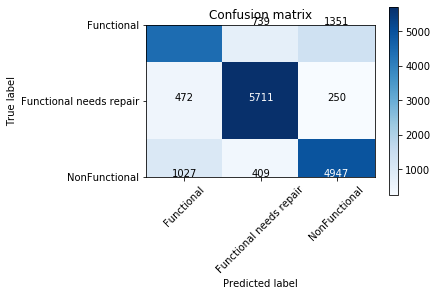

In [152]:
plot_confusion_matrix(cm1, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

In [174]:
testdf = test.drop
(columns = ['id','date_recorded','funder','installer']).values

In [175]:
knnpred= knn.predict(testdf)

In [176]:
predknn= pd.DataFrame(knnpred)

In [180]:
predknn = pd.concat((test['id'], predknn), axis=1)

In [181]:
predknn

,id,id,id,status_group
0,50785,50785,50785,2
1,51630,51630,51630,0
2,17168,17168,17168,0
3,45559,45559,45559,2
4,49871,49871,49871,0
...,...,...,...,...
14845,39307,39307,39307,2
14846,18990,18990,18990,0
14847,28749,28749,28749,0
14848,33492,33492,33492,0


In [179]:
predknn['status_group'].value_counts()

0    8165
2    5506
1    1179
Name: status_group, dtype: int64